<a href="https://colab.research.google.com/github/jeffyelson/IntroductiontoDeepLearning/blob/main/IDL_05_RNN_IMDB_Jeffy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# remove infrequent words. you can play with this parameter as it will likely impact model quality
num_words = 20000
(train_sequences, train_labels), (test_sequences, test_labels) = tf.keras.datasets.imdb.load_data(num_words=num_words)

In [3]:
# look at some sequences. words have been replaced with arbitrary index mappings
# 1 is a special "beginning of sequence" marker
# infrequent words have been replaced by the index 2
# actual words start with index 4, 3 is never used (???)
train_sequences[:3]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 82

In [4]:
# labels are simply binary: sentiment can be positive or negative
train_labels[:3]

array([1, 0, 0])

In [5]:
# to restore words, load the word-to-index mapping
word_to_index = tf.keras.datasets.imdb.get_word_index()

In [6]:
# invert to get index-to-word mapping
index_to_word = dict((index, word) for (word, index) in word_to_index.items())

In [7]:
# we can convert a sequence to text by
# - replacing each index by the respective word
# - joining words together via spaces
# note that we remove the beginning of sequence character and we have to subtract 3 from all indices
# this is because, as mentioned above, the smallest indices are reserved for special characters
# but for some reason this is not reflected in the mapping...
" ".join([index_to_word.get(index - 3, "UNKNOWN") for index in train_sequences[0][1:]])

"this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert UNKNOWN is an amazing actor and now the same being director UNKNOWN father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the UNKNOWN of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be pr

In [24]:
# we cannot create a dataset :( this is because sequences are different length
# but tensors have to be "rectangular"
train_data = tf.data.Dataset.from_tensor_slices(train_sequences, train_labels)

ValueError: ignored

In [25]:
# solution is padding all sequences to the maximum length.
# first find the maximum length
sequence_lengths = [len(sequence) for sequence in train_sequences]
max_len = max(sequence_lengths)
max_len

2494

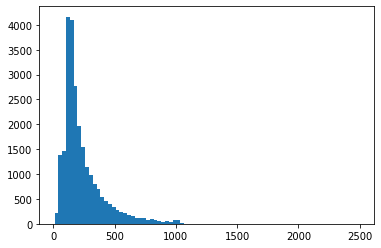

In [26]:
# overview over sequence lengths in the data
# could also look at mean, median, standard deviation...
plt.hist(sequence_lengths, bins=80)
plt.show()

In [27]:
# luckily there is a convenient function for padding
train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len)

In [28]:
# now we can create a dataset!
train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels))


In [29]:
# all sequences are... very long
train_sequences_padded.shape

(25000, 2494)

In [30]:
# it would be better to do something like this
# all sequences above maxlen will be truncated to that length
# note: pad_sequences has "pre" and "post" options for both padding and truncation. one may be better than the other!
train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=200)
train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels))

train_sequences_padded.shape
train_data = train_data.shuffle(buffer_size=20000).batch(100)

In [31]:
# for fun, you can look at the word-index mappings.
# in this case, the mapping was done according to word frequency.
# you can pass reverse=True to sorted() to look at the least common words.
sorted(index_to_word.items())[:100]

[(1, 'the'),
 (2, 'and'),
 (3, 'a'),
 (4, 'of'),
 (5, 'to'),
 (6, 'is'),
 (7, 'br'),
 (8, 'in'),
 (9, 'it'),
 (10, 'i'),
 (11, 'this'),
 (12, 'that'),
 (13, 'was'),
 (14, 'as'),
 (15, 'for'),
 (16, 'with'),
 (17, 'movie'),
 (18, 'but'),
 (19, 'film'),
 (20, 'on'),
 (21, 'not'),
 (22, 'you'),
 (23, 'are'),
 (24, 'his'),
 (25, 'have'),
 (26, 'he'),
 (27, 'be'),
 (28, 'one'),
 (29, 'all'),
 (30, 'at'),
 (31, 'by'),
 (32, 'an'),
 (33, 'they'),
 (34, 'who'),
 (35, 'so'),
 (36, 'from'),
 (37, 'like'),
 (38, 'her'),
 (39, 'or'),
 (40, 'just'),
 (41, 'about'),
 (42, "it's"),
 (43, 'out'),
 (44, 'has'),
 (45, 'if'),
 (46, 'some'),
 (47, 'there'),
 (48, 'what'),
 (49, 'good'),
 (50, 'more'),
 (51, 'when'),
 (52, 'very'),
 (53, 'up'),
 (54, 'no'),
 (55, 'time'),
 (56, 'she'),
 (57, 'even'),
 (58, 'my'),
 (59, 'would'),
 (60, 'which'),
 (61, 'only'),
 (62, 'story'),
 (63, 'really'),
 (64, 'see'),
 (65, 'their'),
 (66, 'had'),
 (67, 'can'),
 (68, 'were'),
 (69, 'me'),
 (70, 'well'),
 (71, 'than'),


In [32]:
train_sequences_padded[0].shape

(200,)

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss_fn = tf.losses.BinaryCrossentropy(from_logits=True)

In [35]:
# here is a high-level sketch for training RNNs
U = tf.Variable(tf.random.uniform(shape = [100,100],minval=-0.1, maxval=0.1, seed=None))
V = tf.Variable(tf.random.uniform(shape = [100,100],minval=-0.1, maxval=0.1, seed=None))
W = tf.Variable(tf.random.uniform(shape = [100,100],minval=-0.1, maxval=0.1, seed=None))
b = tf.Variable(np.zeros(20000, dtype=np.float32))
c = tf.Variable(np.zeros(20000, dtype=np.float32))


# training loop -- same thing as before!!
# our data is now slightly different (each batch of sequences has a time axis, which is kinda new)
# but all the related changes are hidden away at lower levels
def train_loop():
    for sequence_batch, label_batch in train_data:
      train_step(sequence_batch, label_batch)



# a single training step -- again, seems familiar?
def train_step(sequences, labels):
    #print(sequences[:100])
    with tf.GradientTape() as tape:
        logits = rnn_loop(sequences)
        loss = loss_fn(labels, logits)



    variables = [U,V,W,b,c]
    gradients = tape.gradient(loss, variables)
      
    optimizer.apply_gradients(zip(gradients, variables))
    preds = tf.argmax(logits, axis=1, output_type=tf.int64)
    acc = tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))
    print("Training Loss: {} Accuracy: {}".format(loss, acc))
        

# here's where things start to change
# we loop over the input time axis, and at each time step compute the new
# hidden state based on the previous one as well as the current input
# the state computation is hidden away in the rnn_step function and could be
# arbitrarily complex.
# in the general RNN, an output is computed at each time step, and the whole
# sequence is returned. but in this case, since we only have one label for the
# entire sequence, we only use the final state to compute one output and return it.
# before the loop, the state need to be initialized somehow.


def rnn_loop(sequences):
  
    old_state = tf.Variable(np.zeros((100,20000), dtype=np.float32))

    for step in range(128):
        x_t = sequences[:,step]
        x_t = tf.one_hot(x_t, depth=num_words)

        new_state = rnn_step(old_state, x_t)
        

        old_state = new_state

    o_t = output_layer(new_state)
    o_t = tf.keras.layers.Dense(1)(o_t)

    return o_t


# see formulas in the book ;)
def rnn_step(state, x_t):
  val1 = tf.matmul(U,x_t)
  val2 = tf.matmul(W,state)
  at = val1 + val2+b 
  ht = tf.nn.tanh(at)
  return ht

def output_layer(new_state):
  out = c+tf.matmul(V,new_state)
  return out


In [36]:
train_loop()

Training Loss: 0.6929500699043274 Accuracy: 0.5199999809265137
Training Loss: 0.7048528790473938 Accuracy: 0.5699999928474426
Training Loss: 0.7198087573051453 Accuracy: 0.44999998807907104
Training Loss: 0.9476001262664795 Accuracy: 0.5
Training Loss: 1.090156078338623 Accuracy: 0.5199999809265137
Training Loss: 0.8144937753677368 Accuracy: 0.6100000143051147
Training Loss: 1.160149335861206 Accuracy: 0.5400000214576721
Training Loss: 1.6205350160598755 Accuracy: 0.5099999904632568
Training Loss: 1.8817635774612427 Accuracy: 0.5600000023841858
Training Loss: 2.3287742137908936 Accuracy: 0.4000000059604645
Training Loss: 0.922217845916748 Accuracy: 0.46000000834465027
Training Loss: 3.155104398727417 Accuracy: 0.47999998927116394
Training Loss: 4.519530773162842 Accuracy: 0.5600000023841858
Training Loss: 0.7221064567565918 Accuracy: 0.5099999904632568
Training Loss: 3.5134999752044678 Accuracy: 0.4300000071525574
Training Loss: 1.7687726020812988 Accuracy: 0.4699999988079071
Training 

In [37]:
test_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len)

In [38]:
test_sequences_padded.shape

(25000, 2494)

In [39]:
test_data = tf.data.Dataset.from_tensor_slices((test_sequences_padded, test_labels))


In [40]:
test_data = test_data.shuffle(buffer_size=20000).batch(100)

In [45]:
def test_loop():
  for sequence_batch,labels in test_data:
      out=rnn_loop(sequence_batch)
      loss = loss_fn(labels, out)
      preds = tf.argmax(out, axis=1, output_type=tf.int64)
  acc = tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))
  print("Test Loss: {} Test Accuracy: {}".format(loss, acc))

In [46]:
test_loop()

Test Loss: 0.6932953596115112 Test Accuracy: 0.5400000214576721
